![Kickstarter](misc/kickstarter_logo.png)

# Results of the Analysis of Kickstarter Projects
#### Data taken from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects)

---
### Table of Contents:
* [1.)](#introduction) About Kickstarter and its Projects
* [2.)](#content_of_nb) Goal of this Notebook (Questions to be answered)
* [x.)](#main_categories_analysis) Analysis of the Main Categories
* [x.)](#price_analysis) Analysis of the Project Sizes (regarding the Prices)
* [x.)](#runtime_analysis) Analysis of the Project Runtimes
* [5.)](#combined_analysis) Combined Analysis of the first three questions
* [6.)](#result) Results



---
<a id='introduction'></a>
## 1.) About Kickstarter and its Projects


TODO

---
<a id='content_of_nb'></a>
## 2.) Goal of this Notebook (Questions to be answered)

TODO

#### Data

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from collections import defaultdict

filename = 'data/ks-projects-201801.csv'
df = pd.read_csv(filename)

#### Original Format

In [2]:
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00


A quick look at the data shows that...
- there are some columns which aren't necessary for the questions of this notebook and therefore can be dropped
- some of the columns need to be converted to take full advantage of them (e.g. column 'launched')
- there are interesting combinations of columns which could offer some more information (e.g. the runtime of a project)

In [3]:
# remove columns which aren't used during analysis
df.drop(['usd pledged', 'usd_pledged_real', 'usd_goal_real'], axis=1, inplace=True)

# convert launched and deadline columns
from datetime import datetime
df['launched'] = df['launched'].apply(lambda x: datetime.strptime(x[:10], "%Y-%m-%d"))
df['deadline'] = df['deadline'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d"))
df['year_deadline'] = df['deadline'].apply(lambda x: x.year)

# calculate the runtime of the project
df['project_runtime'] = df['deadline'] - df['launched']
df['project_runtime'] = df['project_runtime'].apply(lambda x: int(x.days)) # project runtime in days

#### Format after Conversion

In [4]:
df.head(3)

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,year_deadline,project_runtime
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11,0.0,failed,0,GB,2015,59
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02,2421.0,failed,15,US,2017,60
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12,220.0,failed,3,US,2013,45


---
<a id='main_categories_analysis'></a>
## x.) Analysis of the Main Categories

In [5]:
type(df)

pandas.core.frame.DataFrame

In [29]:
def textplot(df, div_by, col, xlabel='_', ylabel='_', title='_', use_overall_stats=True, figsize_inches=(15, 12)):
    '''
    Plots the ratio how often the values of the 'col' column occur 
    together with the values of the 'div_by' column (pairwise)
    as a scatter plot where the data points are text annotations.
    Example: If value "Games" of column 'col' occurs 70% of the time together with value "Success" of column 'div_by', 
    the text annotation will be plotted at the coordinates ([location of "Success" on x-axis], 0.70).
    Does not work well if there are too many possible values in one of the columns (e.g. for numeric columns)!
    Args:
    - df:                          DataFrame with the data for analysis
    - div_by:                      Column with the Values for X-Axis
    - col:                         Column with the Values to be analyzed
    - xlabel(optional):            Labels for X-Axis
    - ylabel(optional):            Labels for Y-Axis
    - title(optional):             Title of the Plot
    - use_overall_stats(optional): Plot the Overall Statistics of the X-Axis Values too as red dots
    - figsize_inches(optional)     Size of the Plot
    '''
    
    # Inputhandling
    assert str(type(df)) == "<class 'pandas.core.frame.DataFrame'>", "Input df is not a pandas DataFrame."
    assert div_by in df.columns and col in df.columns, "Input columns (xcol and/or ycol) not in given DataFrame."
    assert len(figsize_inches) == 2, "Figsize needs to have a x-value and a y-value. Please enter a tuple."
    
    #Default values
    if xlabel == '_':
        xlabel = div_by
    if ylabel == '_':
        ylabel = 'Ratios'
    if title == '_':
        title = 'Ratio of ' + col + ' in ' + div_by
    
    # Create a Dictionary which holds count_values like this: 
    # ycol = Categories
    # xcol = States
    # Dictionary[Category][State] -> 0.134 (=13.4%)
    occurences_of_div_by_for_col = df.groupby([col])[div_by].value_counts(normalize=True)
    col_div_by_dict = defaultdict(dict)
    for idx, value in enumerate(occurences_of_div_by_for_col):
        col_val, div_by_val = occurences_of_div_by_for_col.index[idx]
        col_div_by_dict[col_val][div_by_val] = value
        # col_div_by_dict named after the keys to get the value
        
    # Prepare values for plotting
    X = []
    Y = []
    annotations = []
    for col_val, div_by_value_dict in col_div_by_dict.items():
        for div_by_val, value in div_by_value_dict.items():
            X.append(div_by_val)        # Values for X Axis
            Y.append(value)             # Values for Y Axis
            annotations.append(col_val) # Text

    # Build plot
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize_inches)
    ax.scatter(x=X, y=Y, s=0.01) # data point is too small to see (-> show only text)
    for idx, txt in enumerate(annotations):
        ax.annotate(txt, xy=(X[idx], Y[idx]), verticalalignment='center', horizontalalignment='center') # places the text annotation at the data point
    if use_overall_stats:
        overall_stats = df[div_by].value_counts(normalize=True)
        ax.scatter(x=list(overall_stats.index), y=list(overall_stats.values), s=100, c='r') # plots overall states ratio as red dots
        plt.legend(["red dots = overall Ratios (not grouped by category)"])
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.title(title)
    plt.show()

In [17]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,year_deadline,project_runtime
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24,35.0,successful,3,US,2009,9
213711,2089078683,New York Makes a Book!!,Journalism,Journalism,USD,2009-05-16,3000.0,2009-04-28,3329.0,successful,110,US,2009,18
342226,813230527,Sponsor Dereck Blackburn (Lostwars) Artist in ...,Rock,Music,USD,2009-05-16,300.0,2009-04-29,15.0,failed,2,US,2009,17
28960,1147015301,"""All We Had"" Gets Into Cannes -- $10 or More G...",Documentary,Film & Video,USD,2009-05-20,300.0,2009-04-30,40.0,failed,4,US,2009,20
196244,199916122,Mr. Squiggles,Illustration,Art,USD,2009-05-22,30.0,2009-05-12,0.0,failed,0,US,2009,10


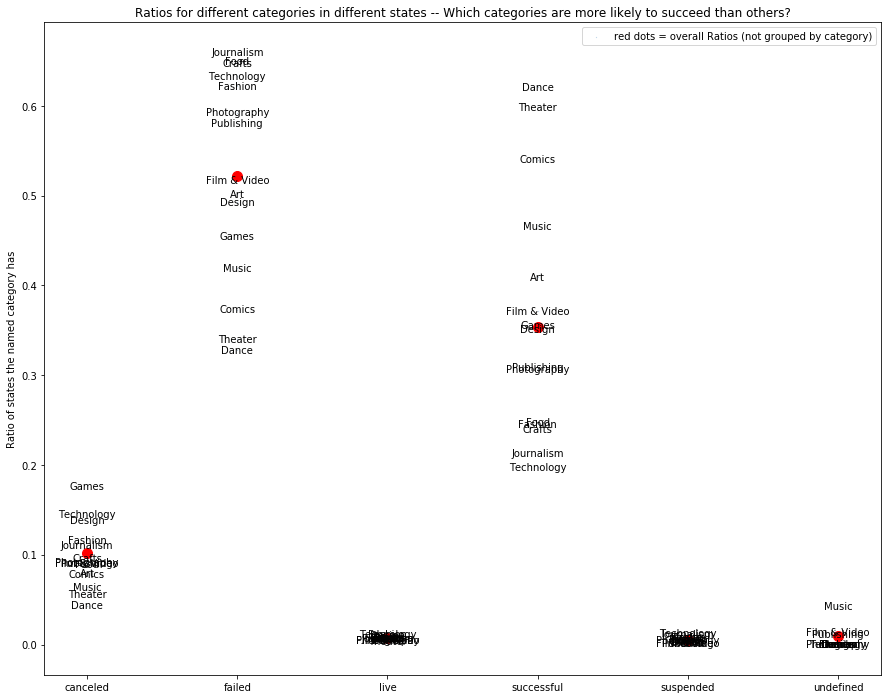

In [30]:
xlabel = ""
ylabel = "Ratio of states the named category has"
title = "Ratios for different categories in different states -- Which categories are more likely to succeed than others?"
textplot(df, 'state', 'main_category', xlabel=xlabel, ylabel=ylabel, title=title)

TODO: Conclusion

In [8]:
successful_cats = ['Dance', 'Theater', 'Comics', 'Music', 'Art']
failed_cats = ['Journalism', 'Food', 'Crafts', 'Technology', 'Fashion', 'Photography', 'Publishing']
canceled_cats = ['Games', 'Technology', 'Design', 'Fashion', 'Journalism']
unsuccessful_cats = list(set().union(failed_cats, canceled_cats)) # merges failed and canceled cats

---
<a id='price_analysis'></a>
## x.) Analysis of the Project Sizes (regarding the Prices)

In [9]:
s1 = df.groupby(['state'])['goal'].mean() #overall avg goal per state
s2 = df.groupby(['main_category','state'])['goal'].mean().loc[successful_cats].groupby(['state']).mean() # avg goal per state for successful categories
s3 = df.groupby(['main_category','state'])['goal'].mean().loc[unsuccessful_cats].groupby(['state']).mean() # avg goal per state for unsuccessful categories
goalsizes = pd.concat([s1.rename('avg_goalsize'), s2.rename('avg_goalsize_successful'), s3.rename('avg_goalsize_unsuccessful')], axis=1).reset_index()
goalsizes.drop(goalsizes.loc[goalsizes['state'].isin(['live', 'suspended', 'undefined'])].index, inplace=True)
goalsizes

,state,avg_goalsize,avg_goalsize_successful,avg_goalsize_unsuccessful
0,canceled,86193.059649,44872.203435,65357.258696
1,failed,67346.845539,42123.175920,55498.234528
3,successful,10162.960544,5307.162505,12291.052442


TODO: Conclusions

---
<a id='runtime_analysis'></a>
## x.) Analysis of the Project Runtimes

In [42]:
def plot_changes_throughout_years(df, col, div_by, xlabel='_', ylabel='_', title='_', yearcol='year_deadline', colordict=None, figsize_inches=(15, 12)):
    '''
    Plots the Changes of a Column throughout the years - the Values of the Column get categorized by Values of another Column ('div_by' Column).
    Args:
    - df:                          DataFrame with the data for analysis
    - col:                         Column with the Values to be analyzed
    - div_by:                      Column with the Values for Categorization
    - xlabel(optional):            Labels for X-Axis
    - ylabel(optional):            Labels for Y-Axis
    - title(optional):             Title of the Plot
    - yearcol(optional):           Name of the Column with the Year-Values
    - colordict(optional):         Dictionary with colors for the possible Categories (one needed for each value in 'div_by')
    - figsize_inches(optional)     Size of the Plot
    '''
    
    # Input Handling
    assert str(type(df)) == "<class 'pandas.core.frame.DataFrame'>", "Input df is not a pandas DataFrame."
    assert col in df.columns and div_by in df.columns, "Input columns (ycol and/or div_by) not in given DataFrame."
    if colordict is not None:
            assert str(type(colordict)) == "<class 'dict'>", "colordict is not a Dictionary"
    assert len(figsize_inches) == 2, "Figsize needs to have a x-value and a y-value. Please enter a tuple."
    
    # Default Values
    if xlabel == '_':
        xlabel = 'Year'
    if ylabel == '_':
        ylabel = 'Average ' + col
    if title == '_':
        title = 'Changeing ' + col + ' over the Years (divided by ' + div_by + ')'
    
    # Calculate the mean col Value for each year divided be the div_by col
    avgs_by_year_and_div = df.groupby([yearcol, div_by])[col].mean()

    # Prepare the values for plotting
    divs = []                        # Values to divide graphs by
    years = defaultdict(list)        # Values for X - Axis
    avg_col_vals = defaultdict(list) # Values for Y  - Axis
    for idx, value in enumerate(avgs_by_year_and_div):
        year, div = avgs_by_year_and_div.index[idx]
        divs.append(div)
        years[div].append(year)
        avg_col_vals[div].append(value)

    # Build the Plot
    fig, ax = plt.subplots()
    fig.set_size_inches(figsize_inches)
    for div in set(divs):
        if colordict is not None:
            ax.plot(years[div], avg_col_vals[div], c=colordict[div], label=div)
        else:
            ax.plot(years[div], avg_col_vals[div], label=div)
    plt.legend()
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    plt.show()

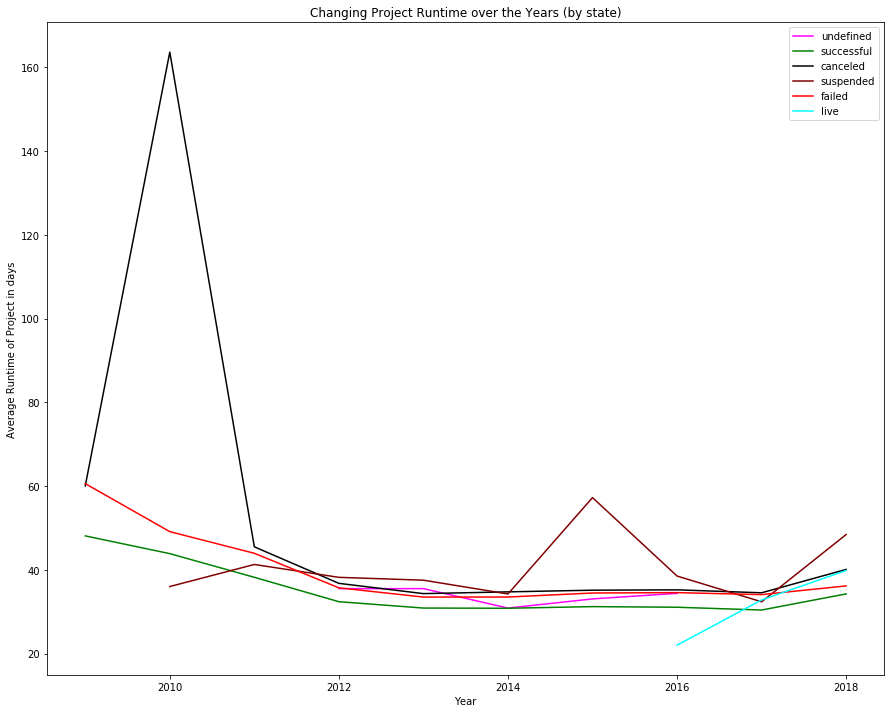

In [43]:
title = "Changing Project Runtime over the Years (by state)"
ylabel = "Average Runtime of Project in days"
xlabel = "Year"
colors = {
    'canceled': 'black',
    'failed': 'red',
    'live': 'cyan',
    'successful': 'green',
    'suspended': 'maroon',
    'undefined': 'magenta'
}
plot_changes_throughout_years(df, 'project_runtime', 'state', xlabel=xlabel, ylabel=ylabel, title=title, colordict=colors)

TODO: Conclusions

---
<a id='combined_analysis'></a>
## 5.) Combined Analysis of the first three questions

In [52]:
def moving_avg(df, col, k):
    '''
    Returns the Moving Average (of the k last values) of a Column.
    Function can be drastically improved -> Save the values in a list/array and add/remove one value for each iteration (TODO)!
    Args:
    - df:  DataFrame with the data
    - col: numerical column of which the moving average is going to be computed
    - k:   bigger k makes the average less sensitive regarding outliers
    Returns:
    - float
    '''
    
    # Input Handling
    assert df[col].dtype in (float, int), 'Column must be numerical'
    
    # Compute Averages
    averages = []
    for idx, row in enumerate(df[col]):
        if idx < k:
            averages.append(round(df[col].iloc[0:idx+1].mean()))
        else:
            averages.append(round(df[col].iloc[idx - k:idx].mean()))
    return averages

In [13]:
df.sort_values(by='deadline', inplace=True)
k = 10000 # value, at which the curves get smoother
moving_avgs = {}
deadlines = {}
for cat in (successful_cats + unsuccessful_cats):
    moving_avgs[cat] = moving_avg(df.loc[df['main_category'] == cat], 'goal', k)
    deadlines[cat] = df['deadline'].loc[df['main_category'] == cat]

In [14]:
def plot_cat_analysis(moving_avgs, deadlines, category, figsize_inches=(15, 8)):
    '''
    TODO
    '''
    
    # Input Handling
    
    # Default Values
    if category in successful_cats:
        c = 'green'
    elif category in unsuccessful_cats:
        c = 'red'
    else:
        c = 'black'
    
    # Build Figure for Subplotting
    fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
    fig.set_size_inches(figsize_inches)
    
    # Build first Plot
    axes[0].plot(deadlines[category], moving_avgs[category], c=c)
    axes[0].set_xlabel("Years")
    axes[0].set_ylabel("Goal Size for the Project")
    axes[0].set_title("Changing goal size for Category {} through the years".format(category))  
    axes[0].xaxis.set_ticks_position('bottom')
    axes[0].yaxis.set_ticks_position('left')
    

    # Prepare Values for second Plot
    years = []
    states = []
    values = []
    df_states_in_tech_per_year = df.groupby(['main_category', 'year_deadline'])['state'].value_counts(normalize=True).loc[category]
    for idx in range(len(df_states_in_tech_per_year)):
        state = df_states_in_tech_per_year.index[idx][1]
        if state in ['successful', 'canceled', 'failed']:
            years.append(df_states_in_tech_per_year.index[idx][0])
            states.append(state)
            values.append(df_states_in_tech_per_year.values[idx])
    for i, txt in enumerate(years):
        axes[1].annotate(txt, (states[i], values[i]),verticalalignment='center', horizontalalignment='center')
        
    # Build second Plot
    axes[1].scatter(states, values, s=0.01)
    axes[1].set_xlim(-0.5, 2.5)
    axes[1].set_title("Stats for Category '{}'".format(category))
    axes[1].set_xlabel("Success States")
    axes[1].set_ylabel("Ratio for the given state")
    plt.show()

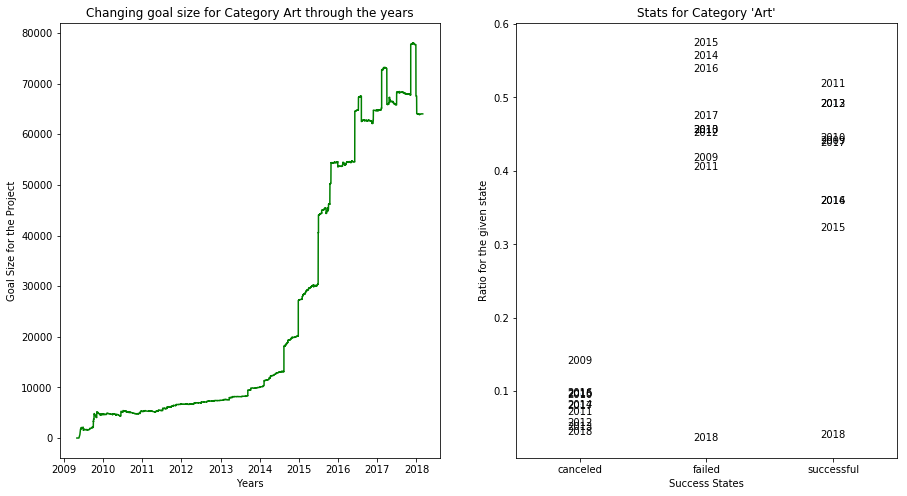

In [15]:
plot_cat_analysis(moving_avgs, deadlines, 'Art')

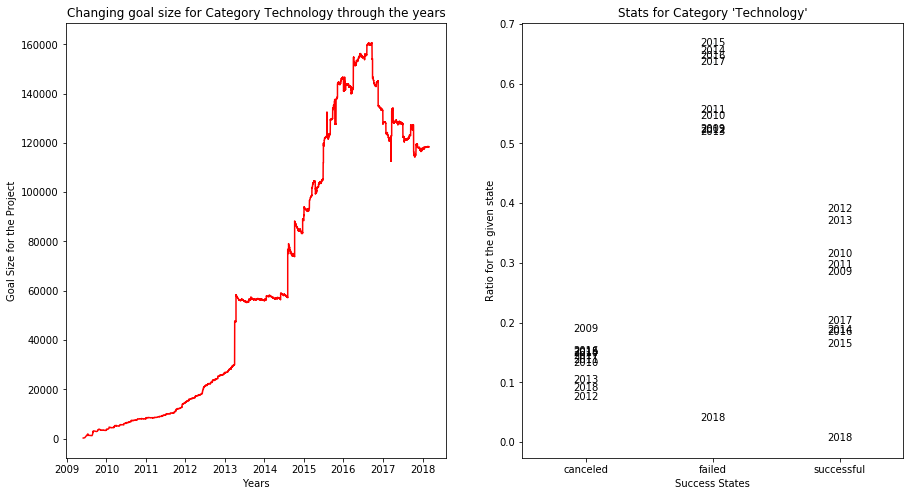

In [16]:
plot_cat_analysis(moving_avgs, deadlines, 'Technology')

TODO: Conclusions

---
<a id='result'></a>
## 6.) Results

TODO